# NZ domestic tourist data

In [5]:
from os import listdir
import matplotlib.pylab as pl
import seaborn as sns
import pandas as pd
import datetime as datetime

In [6]:
import xlrd
from openpyxl import Workbook

In [7]:
data_folder = 'data/'

In [8]:
files = listdir(data_folder)
files

['International & Domestic RTI data for NZ.xlsx']

In [10]:
metadata = pd.read_excel(data_folder + files[0])

In [11]:
metadata

,Name,Type,Role,Definition
0,Year,Int16,Dimension,Year of tourism expenditure
1,Month,V_String,Dimension,Month of tourism expenditure
2,Period,Date,Dimension,Last day of the month during which tourism spe...
3,Visitor Type,V_String,Dimension,International or domestic visitors to New Zealand
4,Region,V_String,Dimension,NZ is divided in 16 regions for devolved local...
5,Regional Tourism Indicator (baseline 100),Double,Measure,The RTI measures the change in level of expend...


In [13]:
data = pd.read_excel(data_folder + files[0], sheetname='Data')

In [14]:
data.shape

(13400, 6)

In [15]:
data.head(2)

,Year,Month,Period,Visitor Type,Region,Regional Tourism Indicator (baseline 100)
0,2008,January,2008-01-31,Domestic,Ashburton District,103
1,2008,January,2008-01-31,Domestic,Auckland,94


Let's start by plotting a single year by Region and possibly visitor type to see if anything interesting jumps out!

First questions:

- how many years?

In [16]:
data.Year.unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [17]:
# data.groupby(['Year', 'Month', 'Visitor Type']).count()

Note: data for 2016 incomplete, only have the first 4 months. Let's focus on 2010 as an example.

In [18]:
# data.groupby('Region').count()

We have 67 Regions (or Territorial Authorities) these would be useful to group on a map so that larger areas can appear. Doing that will take more than an hour though! So the question here is how do we make something interesting with geospatial data but no maps.. 

Ideas:

- how about areas with the biggest changes? If we take 2008 to 2015?

In [19]:
# let's create a datetime column so that we can sort the values:
y_2008 = data[data.Year == 2008].copy()
y_2008 = y_2008.groupby(['Year', 'Region', 'Visitor Type']).mean().reset_index().round(2)
# y_2008

In [20]:
y_2015 = data[data.Year == 2015].copy()
y_2015 = y_2015.groupby(['Year', 'Region', 'Visitor Type']).mean().reset_index().round(2)

In [21]:
# need to separate domestic and international too
y_2008.rename(columns={'Regional Tourism Indicator (baseline 100)': 'RTI_2008'}, inplace=True)
y_2008.head(2)

,Year,Region,Visitor Type,RTI_2008
0,2008,Ashburton District,Domestic,99.83
1,2008,Ashburton District,International,99.92


In [22]:
y_2015.rename(columns={'Regional Tourism Indicator (baseline 100)': 'RTI_2015'}, inplace=True)
y_2015.head(2)

,Year,Region,Visitor Type,RTI_2015
0,2015,Ashburton District,Domestic,132.58
1,2015,Ashburton District,International,105.08


In [23]:
y_2015.shape

(134, 4)

In [24]:
comp_df = pd.merge(y_2008[['Region', 'Visitor Type', 'RTI_2008']],
         y_2015[['Region', 'Visitor Type', 'RTI_2015']], on=['Region', 'Visitor Type'])

In [25]:
comp_df['2008_2015'] = comp_df.RTI_2015 - comp_df.RTI_2008

In [26]:
NUM_EX = 5

In [27]:
comp_df_int = comp_df[comp_df['Visitor Type'] == 'International']
comp_df_dom = comp_df[comp_df['Visitor Type'] == 'Domestic']

In [28]:
top_winners_int = comp_df_int.sort_values(by='2008_2015', ascending=False).head(NUM_EX)
top_winners_int['region_type'] = 'Winner'

top_winners_dom = comp_df_dom.sort_values(by='2008_2015', ascending=False).head(NUM_EX)
top_winners_dom['region_type'] = 'Winner'

In [29]:
top_losers_int = comp_df_int.sort_values(by='2008_2015', ascending=False).tail(NUM_EX)
top_losers_int['region_type'] = 'Loser'

top_losers_dom = comp_df_dom.sort_values(by='2008_2015', ascending=False).tail(NUM_EX)
top_losers_dom['region_type'] = 'Loser'

In [30]:
top_10s_int = pd.concat([top_winners_int, top_losers_int])
top_10s_dom = pd.concat([top_winners_dom, top_losers_dom])

Combine both dataframes by adding an additional categorical column.

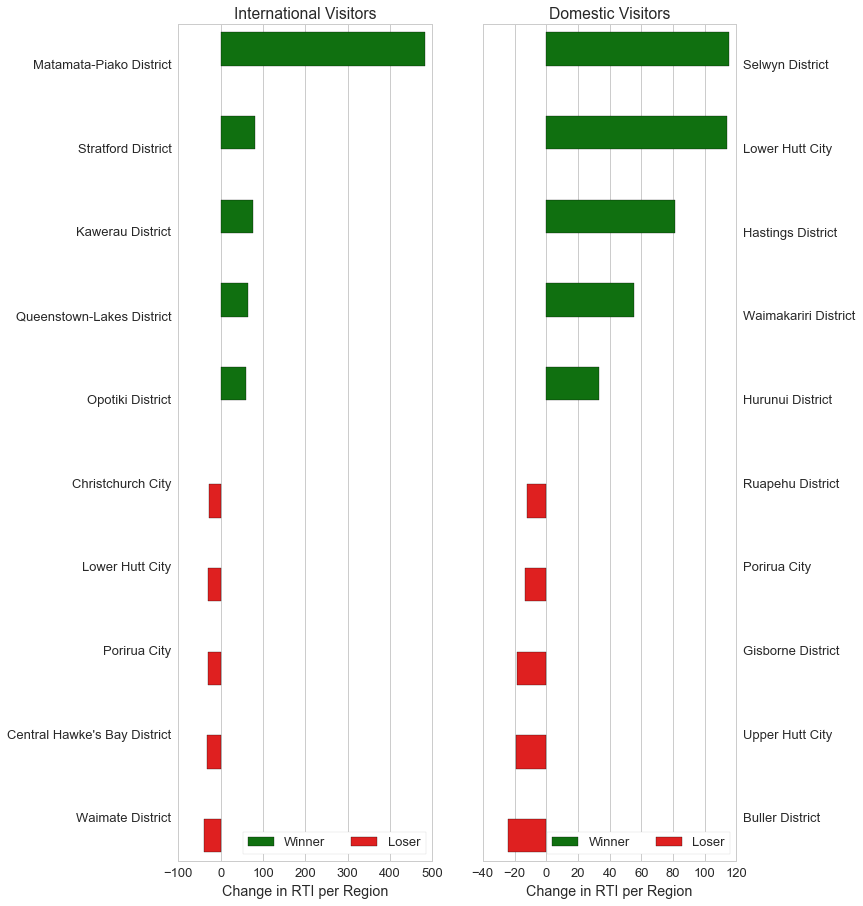

In [31]:
sns.set(style="whitegrid", font_scale=1.3)

pl.figure(figsize=(10, 15))
pl.tight_layout

ax = pl.subplot(1, 2, 1)
sns.barplot(x="2008_2015", y="Region", data=top_10s_int, hue='region_type', hue_order=['Winner', 'Loser'],
           palette={'Winner': 'g', 'Loser': 'r'})
ax.set_ylabel('')
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set_xlabel('Change in RTI per Region')
ax.set_ylabel('')

ax.set_title('International Visitors')

ax2 = pl.subplot(1, 2, 2)
sns.barplot(x="2008_2015", y="Region", data=top_10s_dom, hue='region_type', # hue_order=['Winner', 'Loser'],
           palette={'Winner': 'g', 'Loser': 'r'})

ax2.legend(ncol=2, loc="lower right", frameon=True)
# ax2.legend('')
ax2.set_ylabel('')
# ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position('right')
ax2.set_xlabel('Change in RTI per Region')
ax2.set_title('Domestic Visitors')
pl.savefig('RTI_change_2008_2015.png', bbox_inches='tight')
pl.show()
